<a href="https://colab.research.google.com/github/ffuntik/ML_project_5/blob/master/Face_completion/Image%20completion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Image completion task

## Imports

In [13]:
import time
import numpy as np

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torch_data
import pandas as pd

from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import random

## Working with dataset

In [129]:
olivetti = fetch_olivetti_faces()
X = olivetti.images
y = olivetti.target

data1 = X[:,:,0:32]
target1 = X[:,:,32:64]

data1 = data1.reshape(400, 64*32)
target1 = target1.reshape(400, 64*32)

trainX, testX, trainY, testY =  train_test_split(data1, target1, random_state=0)


input_dim = trainX.shape[1]
output_dim = trainY.shape[1]
batch_size_train = trainX.shape[0]//6
batch_size_test = testX.shape[0]//2

hidden_layer_sizes=[240, 160, 240]

In [130]:
class ImageData(torch_data.Dataset):
    def __init__(self, X, y):
        super(ImageData, self).__init__()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return  self.X[idx], self.y[idx]

In [131]:
train_dset = ImageData(trainX, trainY) 
test_dset = ImageData(testX, testY) 

## ICNN

In [132]:
class DenseICNN(nn.Module):
    def __init__(self, input_dim, output_dim,  hidden_layer_sizes, activation='celu', dropout=0.3):
        super(DenseICNN, self).__init__()
        
        self.hidden_layer_sizes = hidden_layer_sizes
        self.droput = dropout
        self.activation = activation

        self.quadratic_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, output_features, bias=True),
                nn.Dropout(dropout))
            for output_features in hidden_layer_sizes])
        
        sizes = zip(hidden_layer_sizes[:-1], hidden_layer_sizes[1:])
        self.convex_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_features, output_features, bias=True),
                nn.Dropout(dropout))
            for (input_features, output_features) in sizes])
        
        self.final_layer = nn.Linear(hidden_layer_sizes[-1], output_dim, bias=True)
        
                        
    def forward(self, input):
        output = self.quadratic_layers[0](input)
        for quadratic_layer, convex_layer in zip(self.quadratic_layers[1:], self.convex_layers):
            output = convex_layer(output) + quadratic_layer(input)
            if self.activation == 'celu':
                output = torch.celu(output)
        return self.final_layer(output)
    
    def convexify(self):
        for layer in self.convex_layers:
            for sublayer in layer:
                if (isinstance(sublayer, nn.Linear)):
                    sublayer.weight.data.clamp_(0)

In [133]:
ICNN = DenseICNN(input_dim, output_dim,  hidden_layer_sizes, activation='celu') 

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(ICNN.parameters(), lr=0.0038, weight_decay=1e-7) 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.85)

train_loader = torch_data.DataLoader(train_dset, batch_size=batch_size_train, shuffle=True) 
test_loader = torch_data.DataLoader(test_dset, batch_size=batch_size_test, shuffle=False) 

## Training procedure

In [134]:
def train(epochs, ICNN, criterion, optimizer, train_loader, test_loader, scheduler=None, verbose=True, save_dir=None):
    plot = epochs//100
    fig, ax = plt.subplots(ncols=1, nrows=plot, figsize=(3, 3*plot))
    train_graph = []
    test_graph = []
    for epoch in range(1, epochs+1):
        f1 = []
        ICNN.train()
        for X, y in train_loader:
           
            y_out = ICNN(X)
            loss = criterion(y, y_out)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            ICNN.convexify()
            
        ICNN.eval()
        for X, y in test_loader:
            
            y_out = ICNN(X)
            if epoch%100==0:
                ff = X[28]
                bb = np.hstack([ff.unsqueeze(0).reshape(64,32), ICNN(ff).unsqueeze(0).detach().numpy().reshape(64,32)])
                ax[epoch//100-1].imshow(bb, cmap=plt.cm.gray);
                ax[epoch//100-1].axis('off')
            
            test_loss = criterion(y, y_out)
            
        if scheduler is not None:
            scheduler.step()
        freq = max(epochs//20,10)
        if verbose and epoch%freq==0:
            print('Epoch {}/{} || Loss:  Train {:.4f} | Validation {:.4f}'.format(epoch, epochs, loss.item(), test_loss.item()))
        train_graph.append(loss.item())
        test_graph.append(test_loss.item())
    plt.figure(figsize=(10,6))
    plt.plot(range(1,epochs+1), train_graph, c = 'blue', label = 'MSE train')
    plt.plot(range(1,epochs+1), test_graph, c = 'red', label = 'MSE test')
    plt.xlabel('epochs', fontsize=15)
    plt.ylabel('loss', fontsize=15)
    plt.ylim(0, 0.04)
    plt.grid()
    print(min(test_graph))

Epoch 50/1000 || Loss:  Train 0.0426 | Validation 0.0207
Epoch 100/1000 || Loss:  Train 0.0311 | Validation 0.0166
Epoch 150/1000 || Loss:  Train 0.0218 | Validation 0.0150
Epoch 200/1000 || Loss:  Train 0.0182 | Validation 0.0129
Epoch 250/1000 || Loss:  Train 0.0152 | Validation 0.0152
Epoch 300/1000 || Loss:  Train 0.0144 | Validation 0.0120
Epoch 350/1000 || Loss:  Train 0.0126 | Validation 0.0120
Epoch 400/1000 || Loss:  Train 0.0108 | Validation 0.0117
Epoch 450/1000 || Loss:  Train 0.0102 | Validation 0.0117
Epoch 500/1000 || Loss:  Train 0.0098 | Validation 0.0121
Epoch 550/1000 || Loss:  Train 0.0084 | Validation 0.0130
Epoch 600/1000 || Loss:  Train 0.0082 | Validation 0.0108
Epoch 650/1000 || Loss:  Train 0.0080 | Validation 0.0112
Epoch 700/1000 || Loss:  Train 0.0082 | Validation 0.0111
Epoch 750/1000 || Loss:  Train 0.0081 | Validation 0.0116
Epoch 800/1000 || Loss:  Train 0.0067 | Validation 0.0117
Epoch 850/1000 || Loss:  Train 0.0071 | Validation 0.0122
Epoch 900/1000 

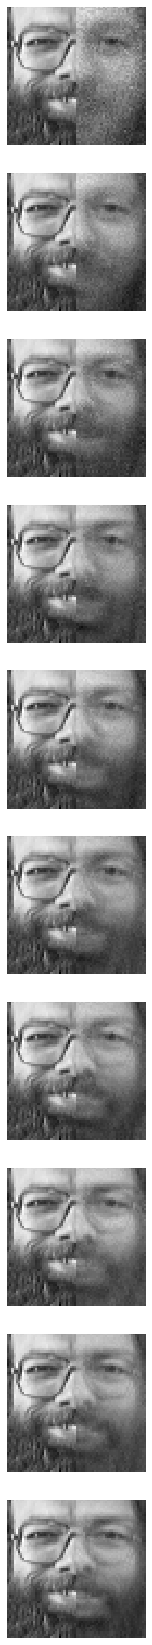

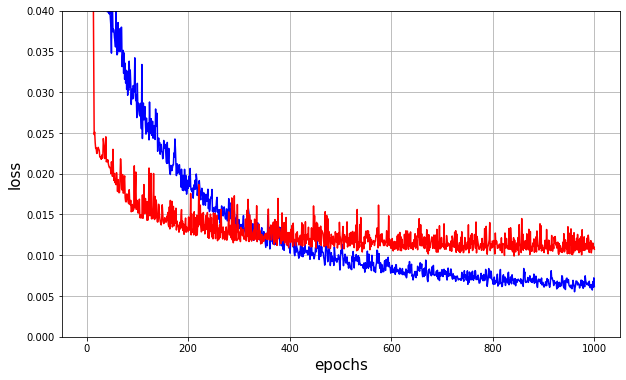

In [135]:
train(1000, ICNN, criterion, optimizer, train_loader, test_loader, scheduler)

In [136]:
test_loader = torch_data.DataLoader(test_dset, batch_size=testX.shape[0], shuffle=False) 
ICNN.eval()
for X, y in test_loader:
    y_out = ICNN(X)
    test_loss = criterion(y, y_out)
print('|| Loss:  Test {:.4f}||'.format(test_loss.item()))

|| Loss:  Test 0.0108||


## Results

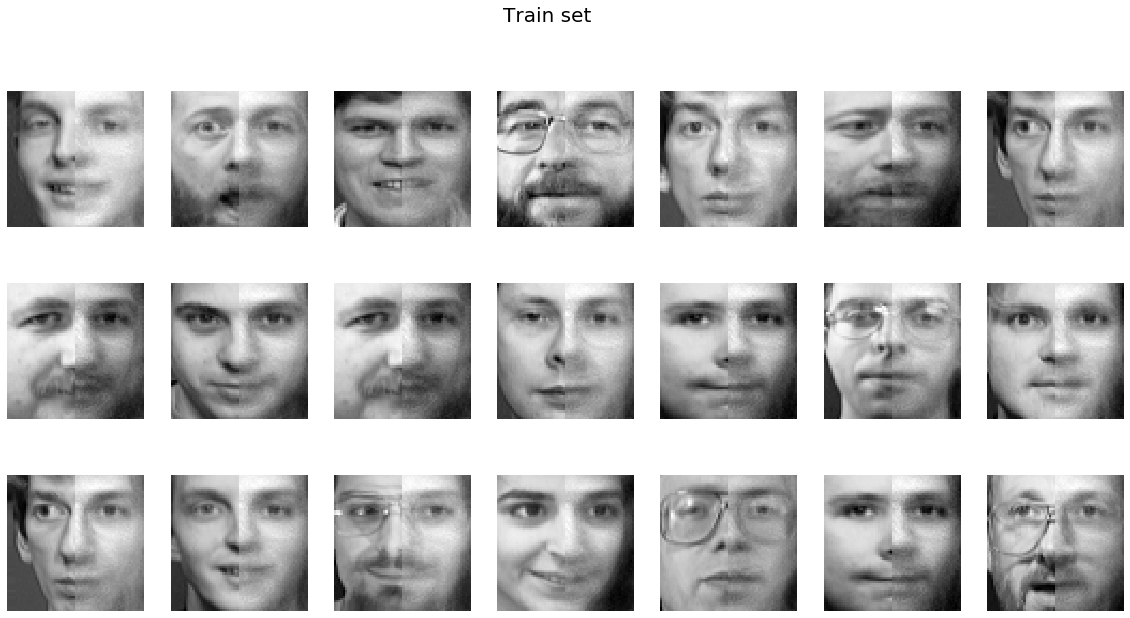

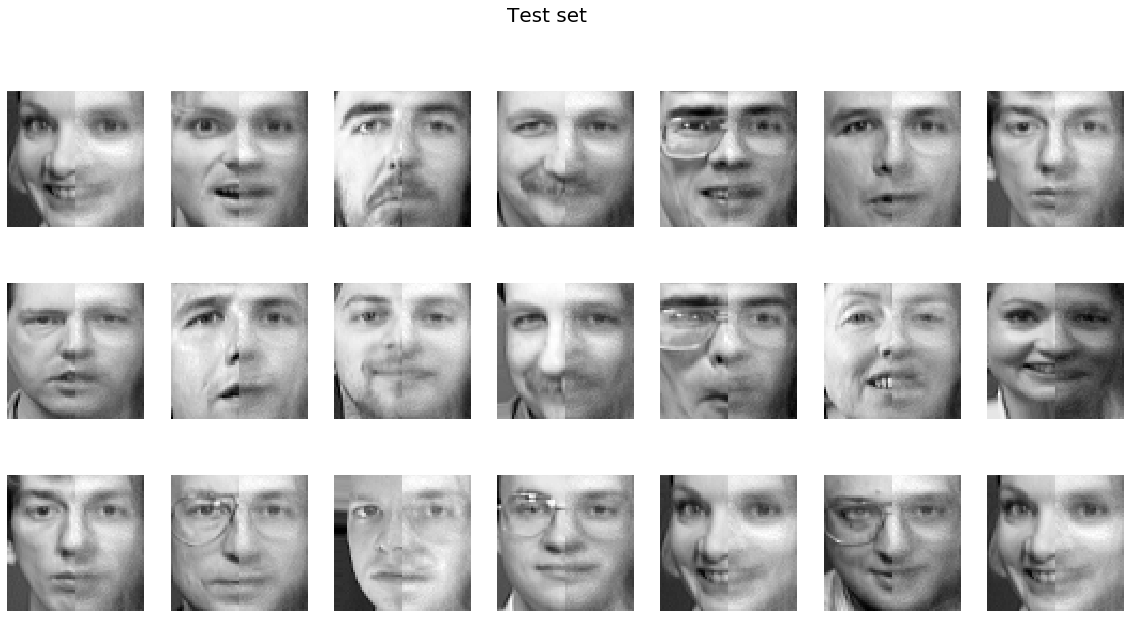

In [141]:
fig, ax = plt.subplots(nrows=3, ncols=7, figsize=(20, 10))
fig.suptitle('Train set', fontsize=20)
for i in range(3):
    for j in range(7):
        a = random.randint(0,299)
        ff = train_dset[a][0]
        bb = np.hstack([ff.unsqueeze(0).reshape(64,32), ICNN(ff.unsqueeze(0)).detach().numpy().reshape(64,32)])
        ax[i][j].imshow(bb, cmap=plt.cm.gray);
        ax[i][j].axis('off')
        
fig, ax = plt.subplots(nrows=3, ncols=7, figsize=(20, 10))
fig.suptitle('Test set', fontsize=20)
for i in range(3):
    for j in range(7):
        a = random.randint(0,99)
        ff = test_dset[a][0]
        bb = np.hstack([ff.unsqueeze(0).reshape(64,32), ICNN(ff.unsqueeze(0)).detach().numpy().reshape(64,32)])
        ax[i][j].imshow(bb, cmap=plt.cm.gray);
        ax[i][j].axis('off')

The end.